In [1]:
# standard python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import statsmodels.api as sm


# my modules
import src.env as env
import src.wrangle as wr
import src.evaluate as evaluate 

# setting random seed to 7
np.random.seed(7)

# turning off red warnings
import warnings
warnings.filterwarnings("ignore")

# module for fixing imported modules
from importlib import reload

In [2]:
df = wr.zillow_2017()

### Some Exploration

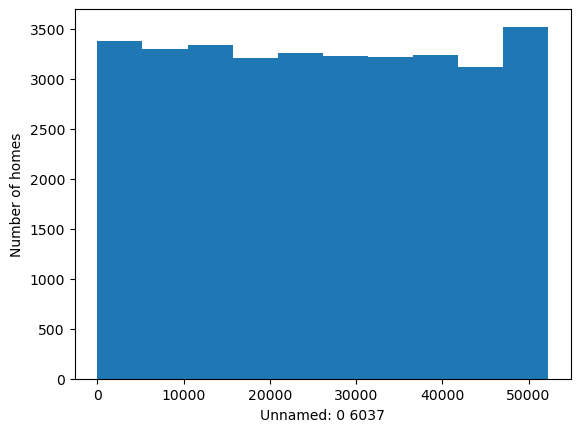

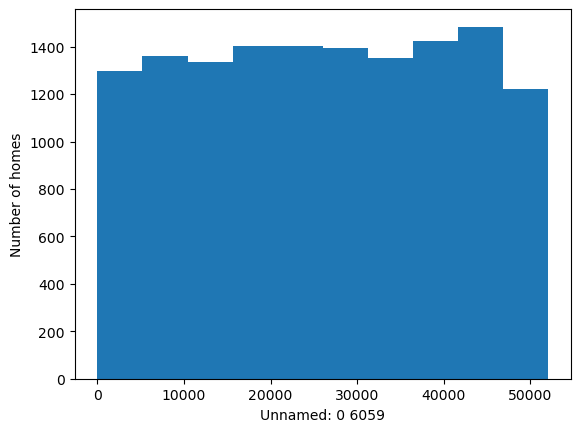

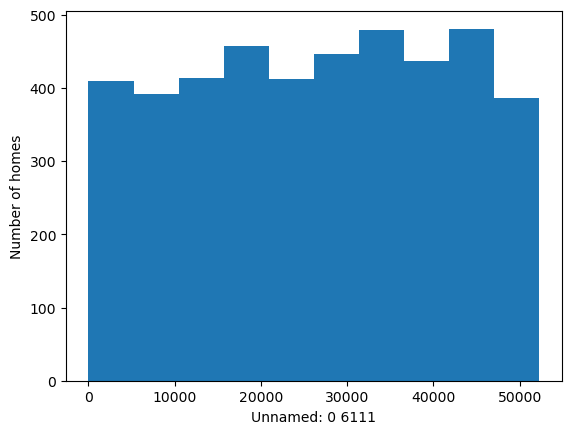

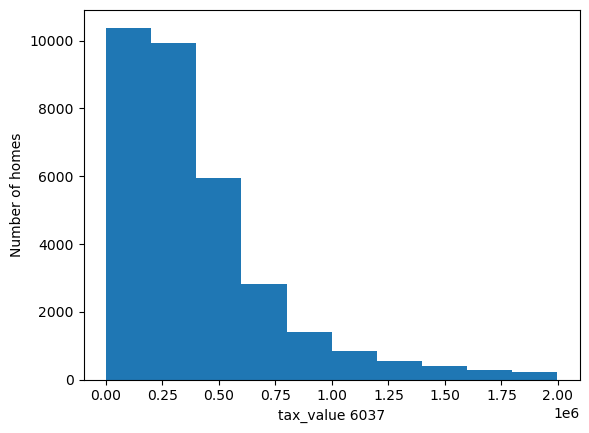

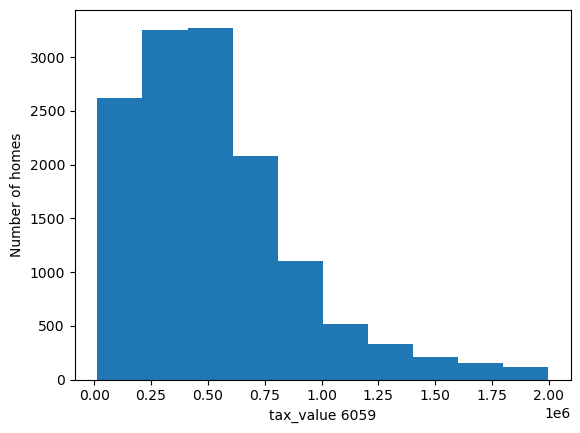

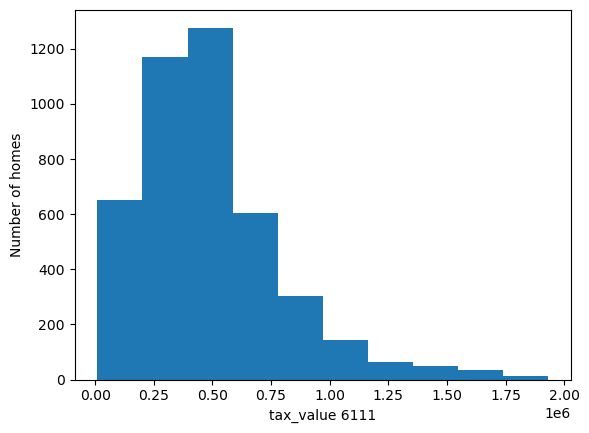

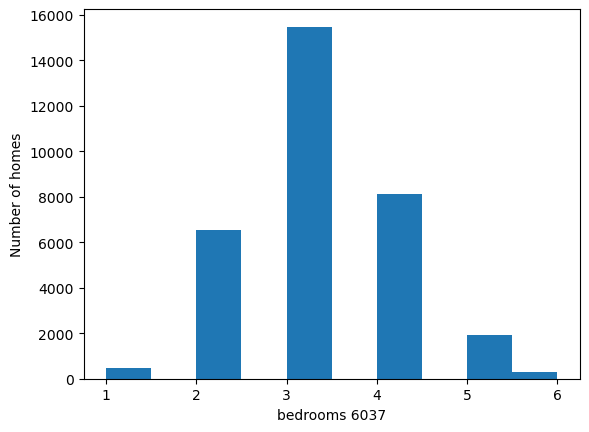

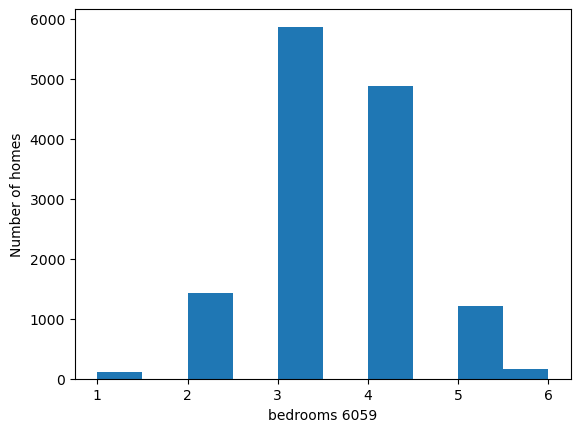

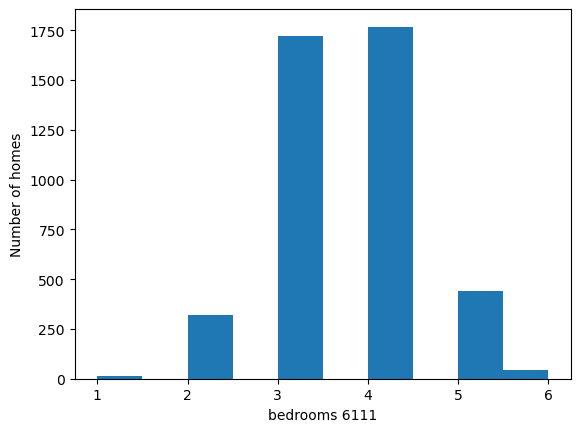

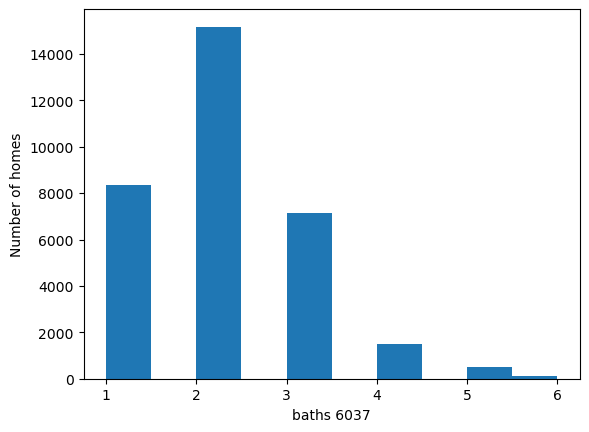

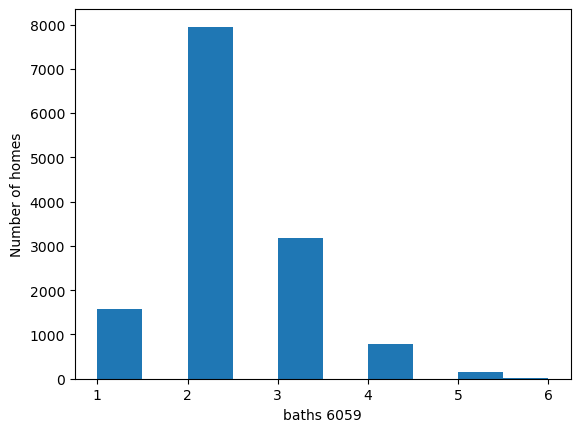

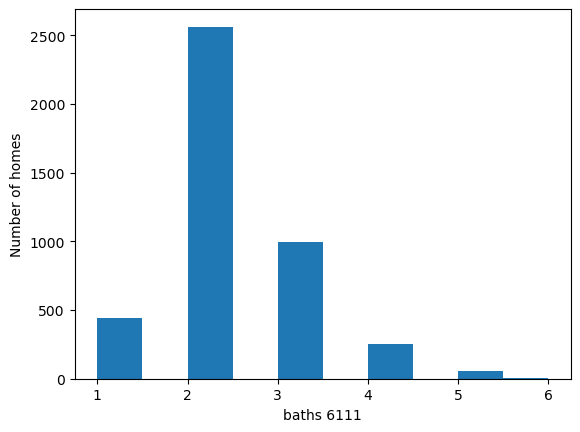

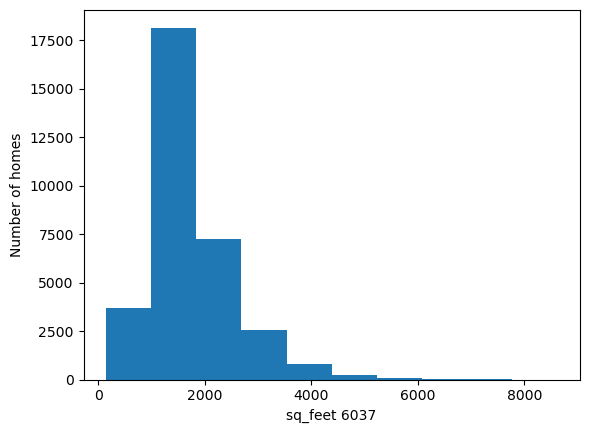

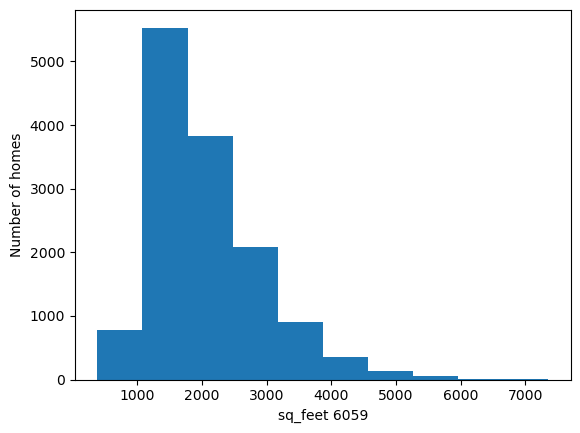

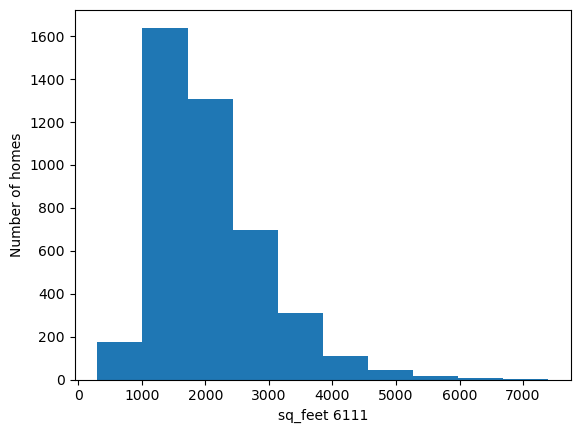

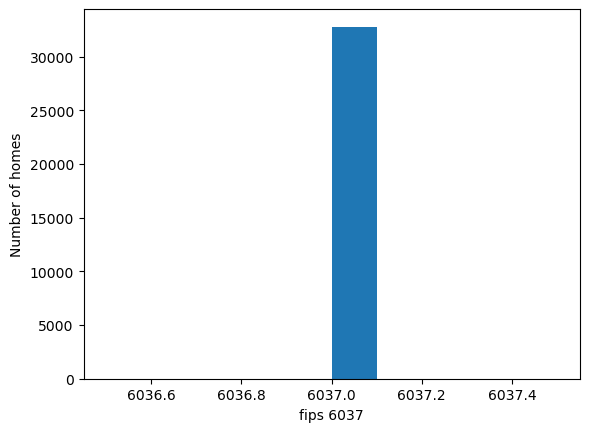

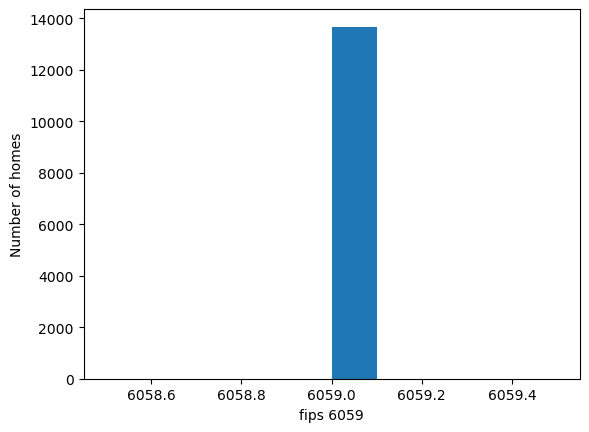

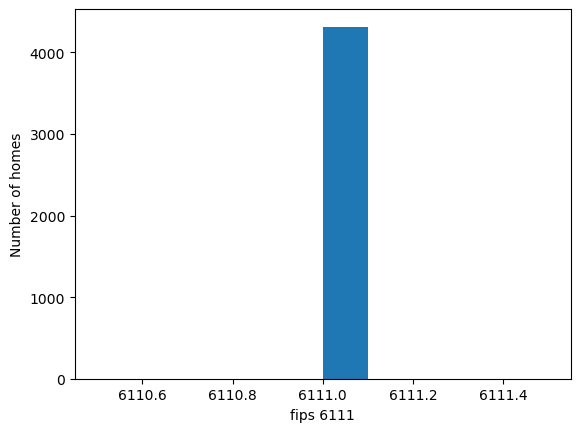

In [3]:
'''
looking at histograms for our county-level, variables: counts per each value in the variable

6037 = Los Angeles County
6059 = Orange County 
6111 = Ventura County
'''
counties = (6037, 6059, 6111)

for i in df.columns:
    for k in counties:
        item = df['fips'] == k
        plt.hist(df[i][item])
        plt.xlabel(f'{i} {k}')
        plt.ylabel('Number of homes')
        plt.show()

In [4]:
#county = df['fips'] == 6037
# 6037 = Los Angeles County
# 6059 = Orange County 
# 6111 = Ventura County

In [5]:
df.columns

Index(['Unnamed: 0', 'tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips'], dtype='object')

### Separating Data into useful data frames

In [6]:
# forming alternate dataframes using the fips information in order to segment by county
keeper_variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']

county = df['fips'] == 6037
la_df = df[keeper_variables][county]

county = df['fips'] == 6059
orange_df = df[keeper_variables][county]

county = df['fips'] == 6111
ventura_df = df[keeper_variables][county]

In [7]:
(la_df.shape[0], orange_df.shape[0], ventura_df.shape[0], 
 la_df.shape[0]+ orange_df.shape[0]+ ventura_df.shape[0], df.shape[0])

(32791, 13671, 4314, 50776, 50776)

In [8]:
# separating our data frames into train, validate and test data frames
# further separates our data into our indepdendent and dependent variables

x_train, y_train, x_validate, y_validate, x_test, y_test = wr.x_y(df, 'tax_value')
la_x_train, la_y_train, la_x_validate, la_y_validate, la_x_test, la_y_test = wr.x_y(la_df, 'tax_value')
or_x_train, or_y_train, or_x_validate, or_y_validate, or_x_test, or_y_test = wr.x_y(orange_df, 'tax_value')
vent_x_train, vent_y_train, vent_x_validate, vent_y_validate, vent_x_test, vent_y_test = wr.x_y(ventura_df, 'tax_value')

In [9]:
(la_y_test.shape[0],or_y_test.shape[0],vent_y_test.shape[0], 
la_y_test.shape[0]+or_y_test.shape[0]+vent_y_test.shape[0], y_test.shape[0])

(6559, 2735, 863, 10157, 10156)

### Creating results data frame for baseline, simple model and filling it

In [10]:
# creating dataframe to hold values for comparison between prediction models
predictions = pd.DataFrame()

# target column is the variable we are trying to predict with machine learning
predictions['target'] = y_train

# produce baseline predictions based on the mean of the tax values and median values
predictions['baseline_mean'] = round(y_train.mean(),3)
predictions['baseline_median'] = y_train.median()

predictions.head()

,target,baseline_mean,baseline_median
21136,584611,443017.919,361507.5
48628,624000,443017.919,361507.5
43340,80226,443017.919,361507.5
24161,124300,443017.919,361507.5
28244,303000,443017.919,361507.5


In [11]:
# creating simple regression model BEFORE splitting by county

# make the model
lm = LinearRegression()

# fit data to simple regression
lm.fit(x_train, y_train)

# make predictions
predictions['simple_model'] = lm.predict(x_train)

In [12]:
# reordering columns in predictions dataframe
predictions = predictions.iloc[:,[1,2,3]]

In [13]:
predictions.columns

Index(['baseline_mean', 'baseline_median', 'simple_model'], dtype='object')

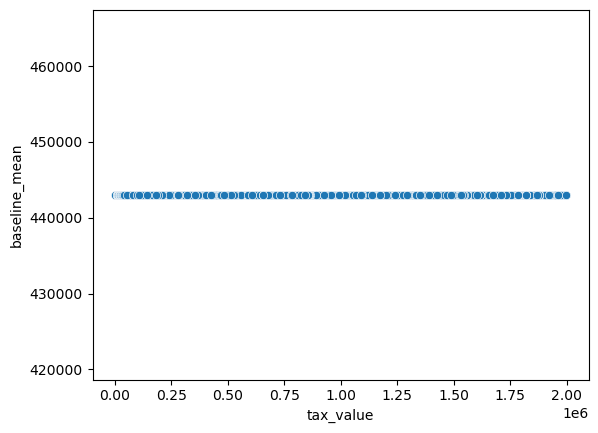

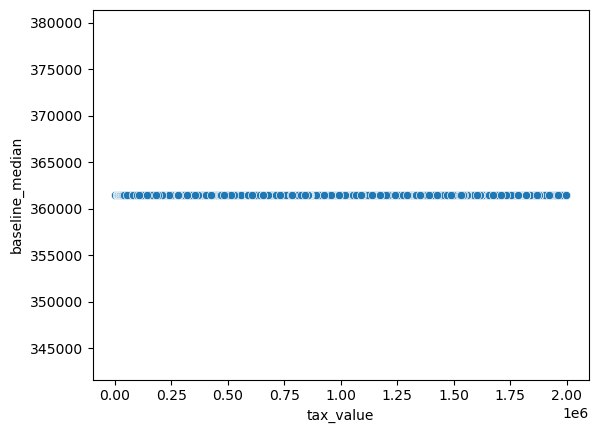

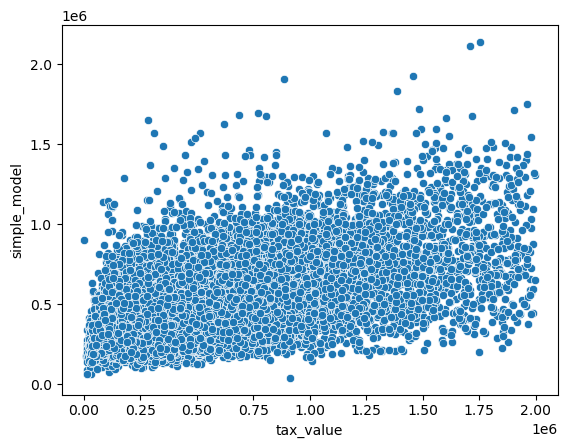

In [33]:
for i in predictions.columns:
    evaluate.plot_residuals(y_train,predictions[i])
    plt.show()

In [16]:
model_evaluation.head()

""


In [25]:
reload(evaluate)

<module 'src.evaluate' from '/Users/CryanRedrose/codeup-data-science/CodeUp/regression_zillow_2017/src/evaluate.py'>

In [31]:

test_test = pd.DataFrame()
for i in predictions.columns:
    test_test = test_test.append(evaluate.regression_errors(y_train, predictions[i], df=True), ignore_index=True)
    #test_test['Model'] = predictions.columns[i]
    #test_test.set_index(predictions.columns[i], inplace=True)


test_test['Model'] = np.array(predictions.columns)
test_test.set_index('Model', inplace=True)
test_test = test_test.T



In [32]:
test_test

Model,baseline_mean,baseline_median,simple_model
ESS,4.000000e-03,1.889140e+14,1.242862e+15
SSE,3.571283e+15,3.760197e+15,2.328421e+15
TSS,3.571283e+15,3.949111e+15,3.571283e+15
MSE,1.255990e+11,1.322430e+11,8.188862e+10
RMSE,3.543995e+05,3.636523e+05,2.861619e+05
R^2,0.000000e+00,4.800000e-02,3.480000e-01
R2V2,-0.000000e+00,-5.300000e-02,3.480000e-01


In [ ]:
columns_names = np.array(predictions.columns)

In [ ]:
predictions

In [ ]:
test_test#.iloc[:,1]

In [ ]:
test_test.set_index('Model', inplace=True)

In [ ]:
predictions.columns[0]

In [27]:
ess, sse, tss, mse, rmse, r2, r2V2 = evaluate.calc_performance(y_train, predictions['baseline_mean'])

In [28]:
r2, r2V2

(1.0153413212628032e-18, -2.220446049250313e-16)